In [225]:
import pandas as pd
import numpy as np
import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from IPython.display import display


pio.templates.default = "seaborn"
pd.options.plotting.backend = "plotly"

%matplotlib inline
%run global.ipynb

In [226]:
%store -r estimates_df

In [227]:
# The specific date to split the data

split_date = pd.to_datetime('2020-03-16')
# split date minus 3 months
earliest_date = split_date - pd.DateOffset(months=12)
to_date = split_date + pd.DateOffset(months=12)
# days between the earliest date and the split date
days_in_before_period = (split_date - earliest_date).days
ratio_minimum_data = 0.9

fixed_outlier_steps_amount = 50000

In [228]:
# Assuming you have the necessary variables like `earliest_date`, `split_date`, and `ratio_minimum_data`
df = estimates_df.copy()

# Ensure all datetime columns are consistent (timezone-naive)
df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
df['created'] = pd.to_datetime(df['created']).dt.tz_localize(None)

# Pre-filter the DataFrame
df_filtered = df[(df['date'] >= earliest_date)]

def process_user_data(user_data):
    user_id = user_data['userId'].iloc[0]
    created_date = user_data['created'].iloc[0]
    # created_date = to_date
    stepsEstimate = user_data['stepsEstimate'].iloc[0]
    gender = user_data['gender'].iloc[0]
    age_range = user_data['ageRange'].iloc[0]
    
    user_data_before = user_data[user_data['date'] < split_date]
    user_data_after = user_data[(user_data['date'] >= split_date) & (user_data['date'] < created_date)]
    
    days_in_after_period = (created_date - split_date).days
    
    steps_before = user_data_before['steps'].mean()
    steps_after = user_data_after['steps'].mean()
    
    if len(user_data_before) < days_in_before_period * ratio_minimum_data or len(user_data_after) < days_in_after_period * ratio_minimum_data:
        return None
    if gender == 'prefer not to say' or gender == 'other' or age_range == 'prefer not to say':
        return None
    if steps_before > fixed_outlier_steps_amount or steps_after > fixed_outlier_steps_amount:
        return None

    change = (steps_after - steps_before) / steps_before
    
    return pd.Series({
        'userId': user_id,
        'stepsBefore': steps_before,
        'stepsAfter': steps_after,
        'daysBefore': len(user_data_before),
        'daysAfter': len(user_data_after),
        'stepsEstimate': stepsEstimate,
        'change': change,
        'gender': gender,
        'ageRange': age_range
    })

# Group the data by userId and apply the function
all_users_df = df_filtered.groupby('userId').apply(process_user_data).dropna()

# Reset the index to get a clean DataFrame
all_users_df.reset_index(drop=True, inplace=True)


average_stepsBefore = all_users_df['stepsBefore'].mean()

# add a column to the DataFrame to indicate if the user is above or below average steps before
all_users_df['above_average'] = all_users_df['stepsBefore'] >= average_stepsBefore

# Output the final DataFrame
all_users_df

,userId,stepsBefore,stepsAfter,daysBefore,daysAfter,stepsEstimate,change,gender,ageRange,above_average
0,5f8925fed211360008c5b33f,8061.450820,16212.748837,366.0,215.0,0.95,1.011145,male,45-54,True
1,5f892b9b6e872e0008c2bb3c,21172.456284,20606.525581,366.0,215.0,-0.45,-0.026730,male,35-44,True
2,5f892bc46e872e0008c56ea5,8100.404372,11477.386047,366.0,215.0,-0.25,0.416891,male,45-54,True
3,5f8953f442c60d0008c35575,8721.650273,10139.320930,366.0,215.0,-0.30,0.162546,female,25-34,True
4,5f8954c142c60d0008c55177,12600.166667,11953.316279,366.0,215.0,-0.15,-0.051337,male,35-44,True
...,...,...,...,...,...,...,...,...,...,...
1098,607ef7c4353afd000905dad7,5583.903030,5575.670977,330.0,401.0,-0.05,-0.001474,male,55-64,False
1099,607f123742a195000908ddfa,4848.339394,6508.261376,330.0,401.0,0.75,0.342369,male,45-54,False
1100,607f2d7007012e0008ab891a,7497.023307,8141.053748,330.0,401.0,0.00,0.085905,male,35-44,False
1101,60c8bbf38b8f7000095fcab2,9265.446023,8096.997722,352.0,439.0,0.00,-0.126108,female,45-54,True


In [229]:
# average daysAfter
average_daysAfter = all_users_df['daysAfter'].mean()
average_daysAfter

299.47325475974617

posx and posy should be finite values
posx and posy should be finite values


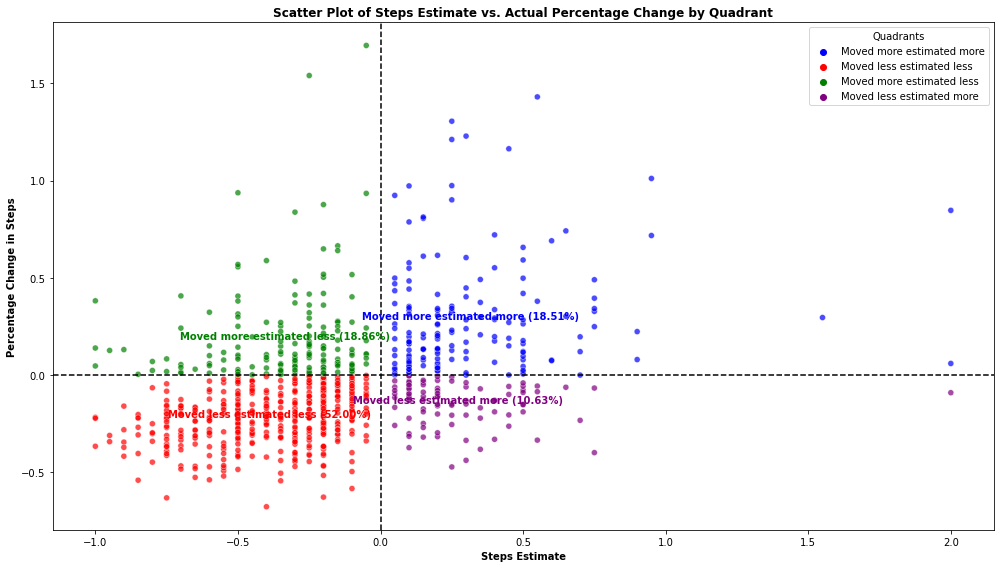

In [230]:
# Assuming your dataframe is named all_users_df and has the columns 'stepsEstimate' and 'change'
df = all_users_df.copy()  # replace this with your actual dataframe

# only take users with stepsEstimate != 0
df = df[df['stepsEstimate'] != 0]

# Define the conditions for each quadrant
conditions = [
    (df['stepsEstimate'] > 0) & (df['change'] > 0),
    (df['stepsEstimate'] > 0) & (df['change'] <= 0),
    (df['stepsEstimate'] <= 0) & (df['change'] > 0),
    (df['stepsEstimate'] <= 0) & (df['change'] <= 0)
]

# Define the quadrant labels
quadrant_labels = ['Moved more estimated more', 'Moved less estimated more', 'Moved more estimated less', 'Moved less estimated less']

# Assign a quadrant label to each data point
df['quadrant'] = np.select(conditions, quadrant_labels, default='Estimated zero')

# Define the color map for the quadrants
quadrant_colors = {
    'Moved more estimated more': 'blue',
    'Moved less estimated more': 'purple',
    'Moved more estimated less': 'green',
    'Moved less estimated less': 'red',
    'Estimated zero': 'grey'
}

# Plot the scatter plot
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=df, 
    x='stepsEstimate', 
    y='change', 
    hue='quadrant', 
    palette=quadrant_colors, 
    alpha=0.7
)

# Add dashed lines for the quadrants
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

# Add labels and title
plt.xlabel('Steps Estimate', fontweight='bold')
plt.ylabel('Percentage Change in Steps', fontweight='bold')
plt.title('Scatter Plot of Steps Estimate vs. Actual Percentage Change by Quadrant', fontweight='bold')

# Annotate each quadrant with the percentage of points it contains
for label, color in quadrant_colors.items():
    count = df[df['quadrant'] == label].shape[0]
    percentage = count / df.shape[0] * 100
    plt.text(
        x=np.mean(df[df['quadrant'] == label]['stepsEstimate']),
        y=np.mean(df[df['quadrant'] == label]['change']),
        s=f"{label} ({percentage:.2f}%)",
        color=color,
        weight='bold',
        ha='center'
    )

# Show the plot
plt.legend(title='Quadrants')
plt.tight_layout()
plt.show()

In [231]:
df = all_users_df.copy()

# Calculate the difference between change and estimate
df['difference'] = df['change'] - df['stepsEstimate']

# Group by gender and ageRange and calculate the median of change, estimate, and difference
grouped_df = df.groupby(['gender', 'ageRange']).agg({
    'change': 'mean',
    'stepsEstimate': 'mean',
    'difference': 'mean',
    'userId': 'count'
}).reset_index()
grouped_df.rename(columns={'userId': 'count'}, inplace=True)

# Format the percentage columns as human-readable percentages
grouped_df['change'] = (grouped_df['change'] * 100).round(2).astype(str) + '%'
grouped_df['stepsEstimate'] = (grouped_df['stepsEstimate'] * 100).round(2).astype(str) + '%'
grouped_df['difference'] = (grouped_df['difference'] * 100).round(2).astype(str) + '%'

# Group by gender only and calculate the same statistics
gender_df = df.groupby(['gender']).agg({
    'change': 'mean',
    'stepsEstimate': 'mean',
    'difference': 'mean',
    'userId': 'count'
}).reset_index()
gender_df['ageRange'] = 'All'
gender_df.rename(columns={'userId': 'count'}, inplace=True)

# Format the percentage columns as human-readable percentages
gender_df['change'] = (gender_df['change'] * 100).round(2).astype(str) + '%'
gender_df['stepsEstimate'] = (gender_df['stepsEstimate'] * 100).round(2).astype(str) + '%'
gender_df['difference'] = (gender_df['difference'] * 100).round(2).astype(str) + '%'

# Calculate the overall statistics across all genders and age ranges
overall_df = pd.DataFrame({
    'gender': ['All'],
    'ageRange': ['All'],
    'change': [(df['change'].mean() * 100).round(2).astype(str) + '%'],
    'stepsEstimate': [(df['stepsEstimate'].mean() * 100).round(2).astype(str) + '%'],
    'difference': [(df['difference'].mean() * 100).round(2).astype(str) + '%'],
    'count': [df.shape[0]]
})

# Combine all dataframes
grouped_df = pd.concat([grouped_df, gender_df, overall_df], ignore_index=True)

# Format the table using tabulate
table = tabulate(grouped_df, headers='keys', tablefmt='psql', showindex=False)

# Print the table
print(table)

+----------+------------+----------+-----------------+--------------+---------+
| gender   | ageRange   | change   | stepsEstimate   | difference   |   count |
|----------+------------+----------+-----------------+--------------+---------|
| female   | 18-24      | -14.33%  | -22.5%          | 5.54%        |      56 |
| female   | 25-34      | -17.7%   | -20.0%          | 8.57%        |      60 |
| female   | 35-44      | -3.41%   | -15.0%          | 8.02%        |     125 |
| female   | 45-54      | -6.32%   | -20.0%          | 14.05%       |     178 |
| female   | 55-64      | -5.74%   | -15.0%          | 14.74%       |     126 |
| female   | 65+        | -2.32%   | 0.0%            | 2.9%         |      61 |
| male     | 18-24      | -11.54%  | -27.5%          | 11.12%       |      40 |
| male     | 25-34      | -7.24%   | -10.0%          | 4.45%        |      99 |
| male     | 35-44      | -2.67%   | -15.0%          | 16.57%       |     105 |
| male     | 45-54      | -4.12%   | -5.

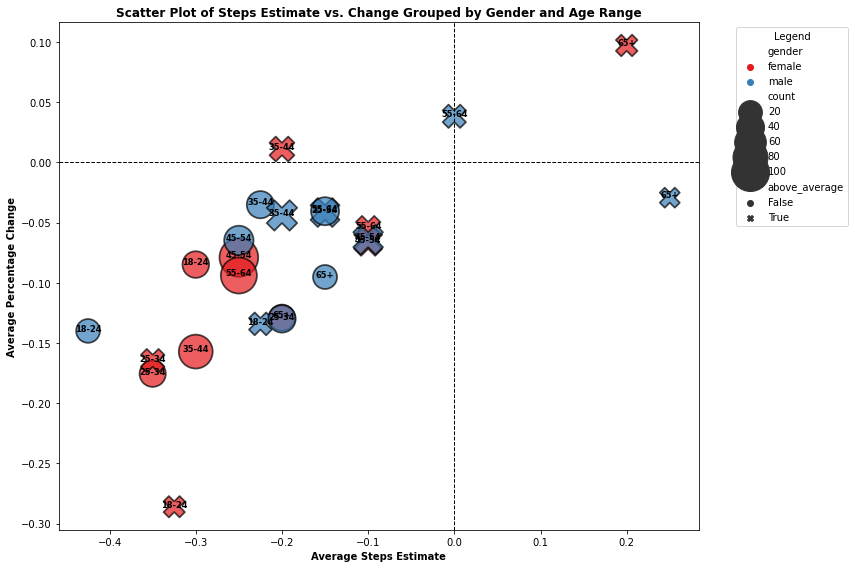

In [247]:
df = all_users_df.copy()

# Calculate the difference between change and estimate
df['difference'] = df['change'] - df['stepsEstimate']

# remove users with stepsEstimate == 0
df = df[df['stepsEstimate'] != 0]

# Group by gender and ageRange and calculate the median of change, estimate, and difference
df = df.groupby(['gender', 'ageRange', 'above_average']).agg({
    'change': 'median',
    'stepsEstimate': 'median',
    'difference': 'median',
    'userId': 'count'
}).reset_index()
df.rename(columns={'userId': 'count'}, inplace=True)

plt.figure(figsize=(12, 8))

# Create scatter plot with uniform marker style (circles)
scatter = sns.scatterplot(
    data=df,
    x='stepsEstimate',
    y='change',
    hue='gender',
    size='count',
    style='above_average',
    sizes=(400, 1500),  # Adjust the range of bubble sizes
    palette='Set1',
    # size_norm=(df['count'].min(), df['count'].max()),  # Normalize bubble sizes
    alpha=0.7,
    edgecolor='black',
)

# Annotate each point with the corresponding ageRange
for line in range(0, df.shape[0]):
    plt.text(
        df.stepsEstimate[line], 
        df.change[line],
        df.ageRange[line],
        horizontalalignment='center',
        size='small',
        color='black',
        weight='semibold'
    )

# Draw reference lines at zero for both axes
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(0, color='black', linestyle='--', linewidth=1)

# Adding labels and title
plt.xlabel('Average Steps Estimate', fontweight='bold')
plt.ylabel('Average Percentage Change', fontweight='bold')
plt.title('Scatter Plot of Steps Estimate vs. Change Grouped by Gender and Age Range', fontweight='bold')

handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

interactive(children=(FloatSlider(value=676.4120879120879, continuous_update=False, description='StepsBefore >…

FloatSlider(value=676.4120879120879, continuous_update=False, description='StepsBefore >', max=28586.677595628…

posx and posy should be finite values
posx and posy should be finite values


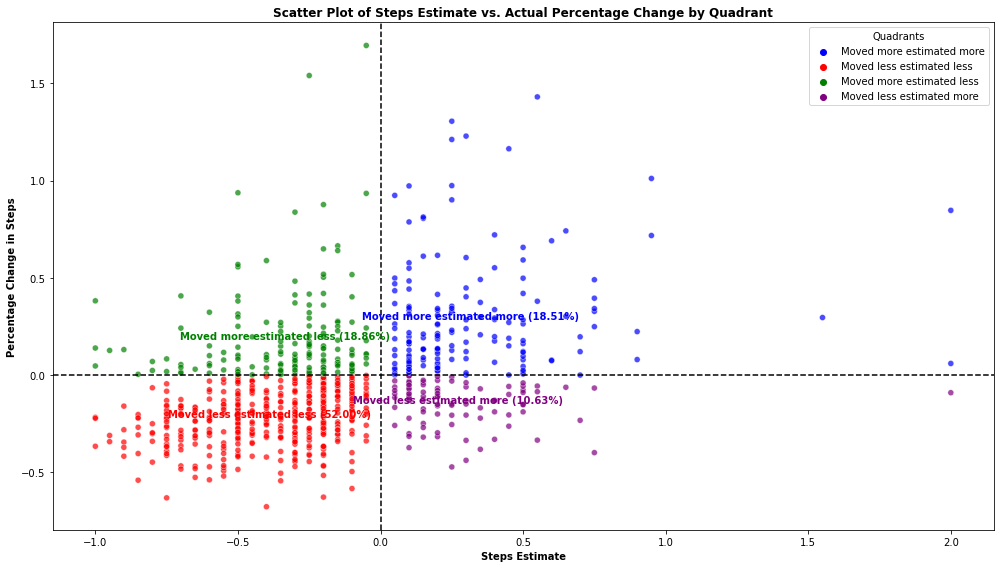

In [ ]:
# Assuming your dataframe is named all_users_df and has the columns 'stepsEstimate' and 'change'
df = all_users_df.copy()  # replace this with your actual dataframe

# only take users with stepsEstimate != 0
df = df[df['stepsEstimate'] != 0]

# Define the conditions for each quadrant
conditions = [
    (df['stepsEstimate'] > 0) & (df['change'] > 0),
    (df['stepsEstimate'] > 0) & (df['change'] <= 0),
    (df['stepsEstimate'] <= 0) & (df['change'] > 0),
    (df['stepsEstimate'] <= 0) & (df['change'] <= 0)
]

# Define the quadrant labels
quadrant_labels = ['Moved more estimated more', 'Moved less estimated more', 'Moved more estimated less', 'Moved less estimated less']

# Assign a quadrant label to each data point
df['quadrant'] = np.select(conditions, quadrant_labels, default='Estimated zero')

# Define the color map for the quadrants
quadrant_colors = {
    'Moved more estimated more': 'blue',
    'Moved less estimated more': 'purple',
    'Moved more estimated less': 'green',
    'Moved less estimated less': 'red',
    'Estimated zero': 'grey'
}

# Plot the scatter plot
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=df, 
    x='stepsEstimate', 
    y='change', 
    hue='quadrant', 
    palette=quadrant_colors, 
    alpha=0.7
)

# Add dashed lines for the quadrants
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

# Add labels and title
plt.xlabel('Steps Estimate', fontweight='bold')
plt.ylabel('Percentage Change in Steps', fontweight='bold')
plt.title('Scatter Plot of Steps Estimate vs. Actual Percentage Change by Quadrant', fontweight='bold')

# Annotate each quadrant with the percentage of points it contains
for label, color in quadrant_colors.items():
    count = df[df['quadrant'] == label].shape[0]
    percentage = count / df.shape[0] * 100
    plt.text(
        x=np.mean(df[df['quadrant'] == label]['stepsEstimate']),
        y=np.mean(df[df['quadrant'] == label]['change']),
        s=f"{label} ({percentage:.2f}%)",
        color=color,
        weight='bold',
        ha='center'
    )

# Show the plot
plt.legend(title='Quadrants')
plt.tight_layout()
plt.show()

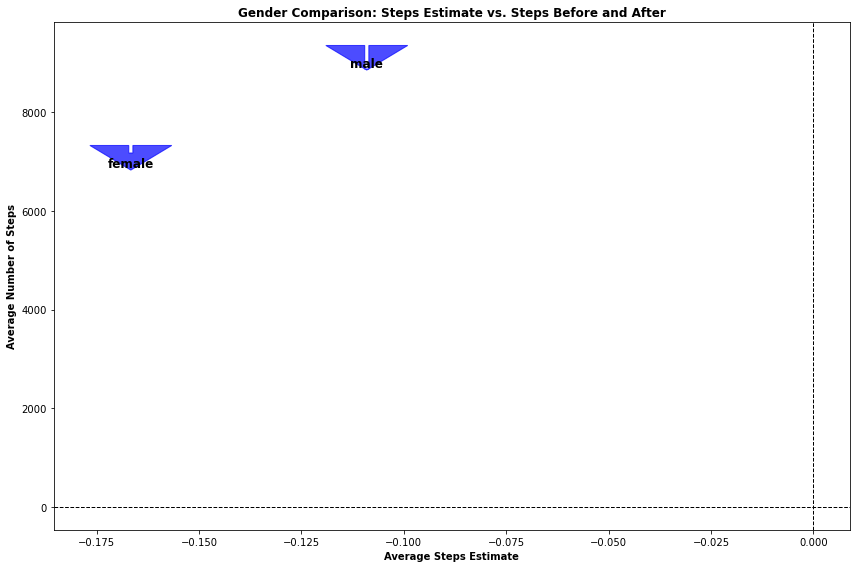

In [234]:
# Calculate the average values for each gender
gender_averages = all_users_df.groupby('gender').agg({
    'stepsBefore': 'mean',
    'stepsAfter': 'mean',
    'stepsEstimate': 'mean'
}).reset_index()

plt.figure(figsize=(12, 8))

# Plot arrows for each gender
for idx, row in gender_averages.iterrows():
    plt.arrow(
        x=row['stepsEstimate'], 
        y=row['stepsBefore'], 
        dx=0,  # No horizontal movement as we're keeping stepsEstimate the same
        dy=row['stepsAfter'] - row['stepsBefore'],  # Vertical change from stepsBefore to stepsAfter
        head_width=0.02,  # Adjust this value for the width of the arrowhead
        head_length=500,  # Adjust this value for the length of the arrowhead
        fc='blue',  # Face color of the arrow
        ec='blue',  # Edge color of the arrow
        alpha=0.7,
        length_includes_head=True
    )
    
    # Annotate the gender label at the end of the arrow
    plt.text(
        x=row['stepsEstimate'], 
        y=row['stepsAfter'], 
        s=row['gender'],
        horizontalalignment='center',
        verticalalignment='bottom',
        fontsize=12,
        fontweight='bold'
    )

# Draw reference lines at zero for both axes
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(0, color='black', linestyle='--', linewidth=1)

# Adding labels and title
plt.xlabel('Average Steps Estimate', fontweight='bold')
plt.ylabel('Average Number of Steps', fontweight='bold')
plt.title('Gender Comparison: Steps Estimate vs. Steps Before and After', fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

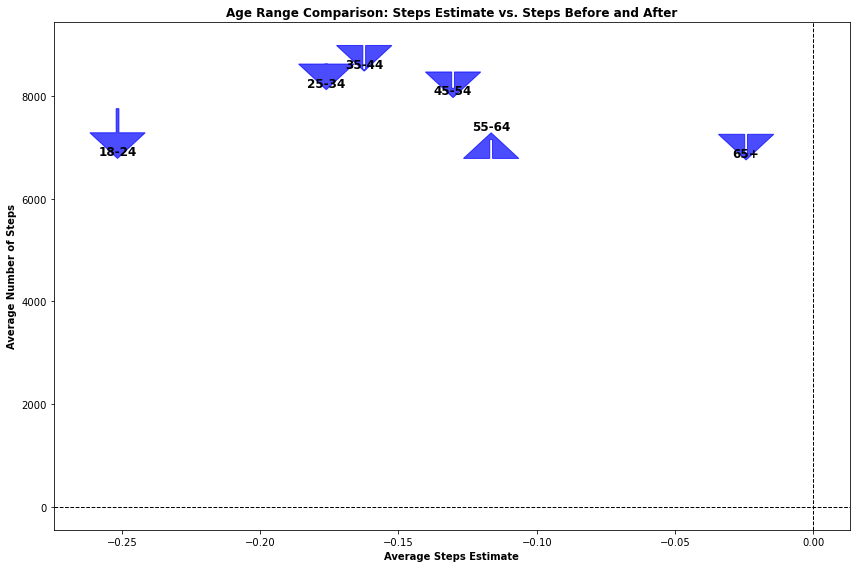

In [235]:

# Calculate the average values for each ageRange
age_range_averages = all_users_df.groupby('ageRange').agg({
    'stepsBefore': 'mean',
    'stepsAfter': 'mean',
    'stepsEstimate': 'mean'
}).reset_index()

plt.figure(figsize=(12, 8))

# Plot arrows for each age range
for idx, row in age_range_averages.iterrows():
    plt.arrow(
        x=row['stepsEstimate'], 
        y=row['stepsBefore'], 
        dx=0,  # No horizontal movement as we're keeping stepsEstimate the same
        dy=row['stepsAfter'] - row['stepsBefore'],  # Vertical change from stepsBefore to stepsAfter
        head_width=0.02,  # Adjust this value for the width of the arrowhead
        head_length=500,  # Adjust this value for the length of the arrowhead
        fc='blue',  # Face color of the arrow
        ec='blue',  # Edge color of the arrow
        alpha=0.7,
        length_includes_head=True
    )
    
    # Annotate the age range label at the end of the arrow
    plt.text(
        x=row['stepsEstimate'], 
        y=row['stepsAfter'], 
        s=row['ageRange'],
        horizontalalignment='center',
        verticalalignment='bottom',
        fontsize=12,
        fontweight='bold'
    )

# Draw reference lines at zero for both axes
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(0, color='black', linestyle='--', linewidth=1)

# Adding labels and title
plt.xlabel('Average Steps Estimate', fontweight='bold')
plt.ylabel('Average Number of Steps', fontweight='bold')
plt.title('Age Range Comparison: Steps Estimate vs. Steps Before and After', fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

In [250]:
# Function to filter data and plot
def plot_filtered_data(steps_before_threshold):
    plt.figure(figsize=(14, 8))

    # Filter the data based on the steps_before_threshold
    filtered_df = all_users_df[all_users_df['stepsBefore'] > steps_before_threshold]
    
    # Loop over each user to plot an arrow with color based on direction
    for idx, row in filtered_df.iterrows():
        # Determine the color based on whether stepsAfter is greater or less than stepsBefore
        arrow_color = 'green' if row['stepsAfter'] > row['stepsBefore'] else 'red'
        
        plt.arrow(
            x=row['stepsEstimate'], 
            y=row['stepsBefore'], 
            dx=0,  # No horizontal movement as we're keeping stepsEstimate the same
            dy=row['stepsAfter'] - row['stepsBefore'],  # Vertical change from stepsBefore to stepsAfter
            head_width=0.02,  # Adjust this value for the width of the arrowhead
            head_length=500,  # Adjust this value for the length of the arrowhead
            fc=arrow_color,  # Face color of the arrow
            ec=arrow_color,  # Edge color of the arrow
            alpha=0.3,  # Set opacity to make overlapping arrows more visible
            length_includes_head=True
        )

    # Add dashed lines for zero reference
    plt.axhline(0, color='black', linestyle='--')
    plt.axvline(0, color='black', linestyle='--')

    # Add labels and title
    plt.xlabel('Steps Estimate', fontweight='bold')
    plt.ylabel('Number of Steps', fontweight='bold')
    plt.title(f'Steps Estimate vs. Steps with StepsBefore > {steps_before_threshold}', fontweight='bold')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Create an interactive slider for stepsBefore threshold
steps_before_slider = widgets.FloatSlider(
    value=0,  # Default value
    min=all_users_df['stepsBefore'].min(),  # Minimum value
    max=all_users_df['stepsBefore'].max(),  # Maximum value
    step=100,  # Step size for the slider
    description='StepsBefore >',
    continuous_update=False  # Update the plot only on release of the slider
)

# Use the interact function to link the slider to the plot function
widgets.interact(plot_filtered_data, steps_before_threshold=steps_before_slider)

# Display the slider
display(steps_before_slider)

interactive(children=(FloatSlider(value=676.4120879120879, continuous_update=False, description='StepsBefore >…

FloatSlider(value=676.4120879120879, continuous_update=False, description='StepsBefore >', max=28586.677595628…